# Proyek Klasifikasi Gambar: Cars Dataset (Stanford)
- **Nama:** Benedictus Aryantio Widarjatmo
- **Email:** benedictusaryantiow@gmail.com
- **ID Dicoding:** M297D5Y0356

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import splitfolders
import shutil
import subprocess
import tqdm
from tqdm import tqdm

## Data Preparation

### Data Loading

In [ ]:
source_dir = 'fruits-360/Training'

# Path sementara untuk menampung 40 kelas terpilih
filtered_dir = 'fruits_selected'
# Path final hasil splitting
output_dir = 'fruits_final_split'

# --- Langkah A: Filter Dataset (Ambil 40 Kelas Saja) ---
# Hapus folder lama jika ada (untuk rerun)
if os.path.exists(filtered_dir):
    shutil.rmtree(filtered_dir)
os.makedirs(filtered_dir)

# Ambil daftar semua buah
all_classes = sorted(os.listdir(source_dir))
# Pilih 40 kelas pertama (~25.000 gambar)
selected_classes = all_classes[:40]

print(f"Mengambil {len(selected_classes)} kelas buah...")

# Hapus folder lama jika ada (untuk rerun agar bersih)
if os.path.exists(filtered_dir):
    shutil.rmtree(filtered_dir)
os.makedirs(filtered_dir)

# Ambil daftar item di source_dir
all_items = os.listdir(source_dir)

# FILTER PENTING:
# 1. Pastikan item tersebut adalah Folder/Directory (os.path.isdir)
# 2. Pastikan bukan file tersembunyi (tidak diawali titik '.')
all_classes = sorted([
    item for item in all_items 
    if os.path.isdir(os.path.join(source_dir, item)) and not item.startswith('.')
])

# Pilih 40 kelas pertama (~25.000 gambar)
selected_classes = all_classes[:40]

print(f"Ditemukan {len(all_classes)} folder valid.")
print(f"Mengambil {len(selected_classes)} kelas buah...")
print(f"Kelas terpilih: {selected_classes}")

# Copy hanya 40 kelas tersebut ke folder filtered_dir
 # Optional: untuk progress bar biar tidak bosan menunggu
for fruit in tqdm(selected_classes, desc="Menyalin Data"):
    src = os.path.join(source_dir, fruit)
    dst = os.path.join(filtered_dir, fruit)
    shutil.copytree(src, dst)

print("Copy data selesai. Melakukan splitting...")

# --- Langkah B: Splitting Data (80% Train, 10% Val, 10% Test) ---
# Kriteria 3: Dataset Dibagi Menjadi Train, Test, dan Validation
splitfolders.ratio(filtered_dir, output=output_dir, seed=1337, ratio=(.8, .1, .1))

print(f"Splitting selesai! Data tersimpan di: {output_dir}")

Mengambil 40 kelas buah...
Ditemukan 225 folder valid.
Mengambil 40 kelas buah...
Kelas terpilih: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Black 2', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1']


Menyalin Data: 100%|██████████| 40/40 [00:07<00:00,  5.53it/s]


Copy data selesai. Melakukan splitting...
Splitting selesai! Data tersimpan di: fruits_final_split


### Data Preprocessing

#### Split Dataset


In [ ]:
# Path baru hasil split
train_path = os.path.join(output_dir, 'train')
val_path = os.path.join(output_dir, 'val')
test_path = os.path.join(output_dir, 'test')

# Augmentasi hanya untuk Train Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation dan Test hanya dire-scale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data Train
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

# Load Data Validation
validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

# Load Data Test (Ini data 'Test' hasil split kita sendiri, bukan dari Kaggle)
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

Found 17032 images belonging to 40 classes.
Found 2117 images belonging to 40 classes.
Found 2161 images belonging to 40 classes.


## Modelling

In [ ]:
model = Sequential([
    # Layer Konvolusi 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),
    
    # Layer Konvolusi 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Layer Konvolusi 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten
    Flatten(),
    
    # Dense Layer
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    # Output Layer
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/Users/home/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,667,880 (25.44 MB)

 Trainable params: 6,667,880 (25.44 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluasi dan Visualisasi
Membuat plot akurasi dan loss dari data training dan validation
Mengevaluasi akurasi akhir model

Epoch 1/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 91s 170ms/step - accuracy: 0.4980 - loss: 1.5755 - val_accuracy: 0.9069 - val_loss: 0.2889
Epoch 2/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 87s 164ms/step - accuracy: 0.8308 - loss: 0.4762 - val_accuracy: 0.9598 - val_loss: 0.1184
Epoch 3/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 115s 215ms/step - accuracy: 0.8863 - loss: 0.3188 - val_accuracy: 0.9702 - val_loss: 0.0780
Epoch 4/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 114s 215ms/step - accuracy: 0.9130 - loss: 0.2479 - val_accuracy: 0.9844 - val_loss: 0.0454
Epoch 5/20
533/533 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9357 - loss: 0.1909
Akurasi Training & Validation > 92%, hentikan training.
533/533 ━━━━━━━━━━━━━━━━━━━━ 105s 196ms/step - accuracy: 0.9365 - loss: 0.1851 - val_accuracy: 0.9934 - val_loss: 0.0183

Evaluasi pada Custom Test Set:
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9977 - loss: 0.0124
Akurasi Test Set: 99.77%


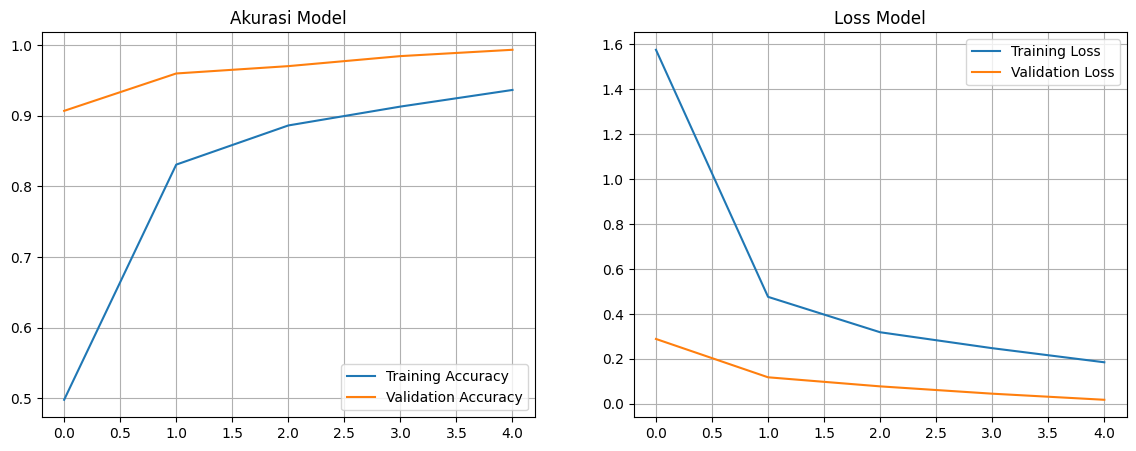

In [ ]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print("\nAkurasi Training & Validation > 92%, hentikan training.")
      self.model.stop_training = True

callbacks = myCallback()

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[callbacks],
    verbose=1
)

# Evaluasi akurasi pada Test Set
print("\nEvaluasi pada Custom Test Set:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi Test Set: {test_acc * 100:.2f}%")

# Plot Akurasi dan Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Akurasi Model')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Model')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

## Konversi Model

In [ ]:
folders_to_make = ['tfjs_model', 'tflite', 'saved_model']

print("--- Memulai Proses Reset Folder ---")
for folder in folders_to_make:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)
    print(f"✅ Folder '{folder}/' berhasil dibuat.")

print("\n--- 1. Membuat SavedModel ---")
tf.saved_model.save(model, 'saved_model')
print("✅ Folder 'saved_model' terisi.")

print("\n--- 2. Membuat TFLite ---")

# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('tflite/label.txt', 'w') as f:
    f.write(labels)

print("✅ Folder 'tflite' terisi.")

print("\n--- 3. Membuat TFJS Model ---")

temp_h5 = 'temp_model_fix.h5'
model.save(temp_h5)

print("⏳ Sedang menjalankan konversi TFJS (metode H5)...")
try:
    
    subprocess.run([
        "tensorflowjs_converter",
        "--input_format=keras",
        temp_h5,
        "tfjs_model"
    ], check=True)
    print("✅ Folder 'tfjs_model' terisi.")
except subprocess.CalledProcessError as e:
    print(f"❌ Gagal konversi TFJS. Error: {e}")
    print("Pastikan library tensorflowjs terinstall dengan benar.")

# Hapus file temporary .h5 agar bersih
if os.path.exists(temp_h5):
    os.remove(temp_h5)

print("\n========================================")
print("       VERIFIKASI ISI FOLDER")
print("========================================")
for folder in folders_to_make:
    print(f"📂 {folder}/")
    if os.path.exists(folder):
        for item in os.listdir(folder):
            if os.path.isdir(os.path.join(folder, item)):
                print(f"   📁 {item}/")
            else:
                print(f"   📄 {item}")

--- Memulai Proses Reset Folder ---
✅ Folder 'tfjs_model/' berhasil dibuat.
✅ Folder 'tflite/' berhasil dibuat.
✅ Folder 'saved_model/' berhasil dibuat.

--- 1. Membuat SavedModel ---
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


✅ Folder 'saved_model' terisi.

--- 2. Membuat TFLite ---
INFO:tensorflow:Assets written to: /var/folders/tb/f700bjm95ml0c4dbr2s18gz40000gp/T/tmpegq9ze6y/assets


INFO:tensorflow:Assets written to: /var/folders/tb/f700bjm95ml0c4dbr2s18gz40000gp/T/tmpegq9ze6y/assets


Saved artifact at '/var/folders/tb/f700bjm95ml0c4dbr2s18gz40000gp/T/tmpegq9ze6y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)
Captures:
  13476515680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476393760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476389184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476388128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6367052192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476393408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476392528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476390768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13476391472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6385213232: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1763643628.288069  134088 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1763643628.289019  134088 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


✅ Folder 'tflite' terisi.

--- 3. Membuat TFJS Model ---
⏳ Sedang menjalankan konversi TFJS (metode H5)...


🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
/Users/home/miniconda3/envs/tf_env/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Folder 'tfjs_model' terisi.

       VERIFIKASI ISI FOLDER
📂 tfjs_model/
   📄 model.json
   📄 group1-shard7of7.bin
   📄 group1-shard5of7.bin
   📄 group1-shard1of7.bin
   📄 group1-shard3of7.bin
   📄 group1-shard6of7.bin
   📄 group1-shard4of7.bin
   📄 group1-shard2of7.bin
📂 tflite/
   📄 label.txt
   📄 model.tflite
📂 saved_model/
   📄 fingerprint.pb
   📁 variables/
   📄 saved_model.pb
   📁 assets/


## Inference (Optional)